# 📚 Text Classification using Graph Embeddings

## 🎯 Mục tiêu
Phân loại văn bản tiếng Việt bằng Graph Embeddings:
- **Data**: 10 files (1-5: núi, 6-10: biển) + 1 file test
- **Method**: Document → Graph → Embeddings → Mean Pooling → KNN
- **Goal**: Predict test.txt là "núi" hay "biển"

## 📋 Pipeline
1. **Load Documents**: Đọc 10 files training + 1 file test
2. **Doc2Graph**: Mỗi document → 1 co-occurrence graph
3. **Graph2Embeddings**: DeepWalk cho mỗi graph
4. **Graph2Vector**: Mean pooling của node embeddings
5. **Classification**: KNN training và prediction
6. **Visualization**: t-SNE, decision boundaries, results

## ⚙️ Configuration

In [1]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Dataset configuration
TRAIN_FILES = list(range(1, 11))  # Files 1-10 for training
LABELS = {
    1: "núi", 2: "núi", 3: "núi", 4: "núi", 5: "núi",
    6: "biển", 7: "biển", 8: "biển", 9: "biển", 10: "biển"
}
TEST_FILE = "test.txt"

# Graph construction parameters
WINDOW_SIZE = 3
MIN_FREQUENCY = 1  # Keep all words for small documents
WEIGHT_METHOD = "frequency"

# Random walk parameters
WALK_LENGTH = 10
NUM_WALKS_PER_NODE = 5

# Word2Vec parameters
VECTOR_SIZE = 64  # Smaller for demo
CONTEXT_WINDOW = 5
MIN_COUNT = 1
EPOCHS = 20
RANDOM_SEED = 42

# Classification parameters
KNN_K = 3

print("✅ Configuration loaded successfully!")
print(f"📊 Training files: {len(TRAIN_FILES)}, Labels: {set(LABELS.values())}")
print(f"🎯 Vector size: {VECTOR_SIZE}, KNN k: {KNN_K}")

✅ Configuration loaded successfully!
📊 Training files: 10, Labels: {'núi', 'biển'}
🎯 Vector size: 64, KNN k: 3


## 📦 Import Libraries

In [2]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random
import warnings
warnings.filterwarnings('ignore')

# Graph processing
import networkx as nx
from collections import defaultdict, Counter

# NLP processing
try:
    from underthesea import word_tokenize
    print("✅ underthesea imported successfully")
except ImportError:
    print("❌ underthesea not found. Install: pip install underthesea")

# Machine Learning
try:
    from gensim.models import Word2Vec
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import cross_val_score, LeaveOneOut
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    from sklearn.manifold import TSNE
    from sklearn.preprocessing import LabelEncoder
    print("✅ ML libraries imported successfully")
except ImportError:
    print("❌ Missing libraries. Install: pip install gensim scikit-learn")

# Set random seeds
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print("🎯 Setup complete!")

✅ underthesea imported successfully
✅ ML libraries imported successfully
🎯 Setup complete!
✅ ML libraries imported successfully
🎯 Setup complete!


## 📂 Step 1: Load Documents

In [3]:
# Load training documents
data_dir = Path("data")
documents = {}
labels_list = []

print("📂 Loading training documents:")
for file_num in TRAIN_FILES:
    file_path = data_dir / f"{file_num}.txt"
    if file_path.exists():
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read().strip()
            documents[file_num] = content
            labels_list.append(LABELS[file_num])
            print(f"  📄 {file_num}.txt ({LABELS[file_num]}): {len(content)} characters")
    else:
        print(f"  ❌ {file_path} not found")

# Load test document
test_path = data_dir / TEST_FILE
test_document = None
if test_path.exists():
    with open(test_path, 'r', encoding='utf-8') as f:
        test_document = f.read().strip()
        print(f"\n🎯 Test document: {len(test_document)} characters")
        print(f"📝 Preview: {test_document[:100]}...")
else:
    print(f"\n❌ {test_path} not found")

print(f"\n📊 Dataset summary:")
print(f"  - Training documents: {len(documents)}")
print(f"  - Label distribution: {Counter(labels_list)}")
print(f"  - Test document: {'✅' if test_document else '❌'}")

📂 Loading training documents:
  📄 1.txt (núi): 1194 characters
  📄 2.txt (núi): 1152 characters
  📄 3.txt (núi): 1155 characters
  📄 4.txt (núi): 1094 characters
  📄 5.txt (núi): 1429 characters
  📄 6.txt (biển): 1898 characters
  📄 7.txt (biển): 1795 characters
  📄 8.txt (biển): 2013 characters
  📄 9.txt (biển): 1973 characters
  📄 10.txt (biển): 2006 characters

🎯 Test document: 1181 characters
📝 Preview: Núi Bà Đen nằm ở tỉnh Tây Ninh, là ngọn núi cao nhất Nam Bộ với độ cao 986 mét so với mực nước biển,...

📊 Dataset summary:
  - Training documents: 10
  - Label distribution: Counter({'núi': 5, 'biển': 5})
  - Test document: ✅


## 🏗️ Step 2: Document to Graph Conversion

Tạo co-occurrence graph cho mỗi document riêng biệt

In [4]:
# Reuse TextGraphBuilder from deepwalk_notebook
class TextGraphBuilder:
    """
    Build co-occurrence graph from Vietnamese text
    """
    def __init__(self, window_size=WINDOW_SIZE, weight_method=WEIGHT_METHOD):
        self.window_size = window_size
        self.weight_method = weight_method
        self.cooccurrence_matrix = defaultdict(lambda: defaultdict(int))
        self.word_counts = defaultdict(int)
        
    def process_text(self, text):
        """Tokenize and clean Vietnamese text"""
        tokens = word_tokenize(text)
        cleaned_tokens = []
        for token in tokens:
            t = token.strip().lower()
            if t:
                cleaned_tokens.append(t)
        return cleaned_tokens
    
    def build_cooccurrence_matrix(self, tokens):
        """Build co-occurrence matrix with sliding window"""
        self.cooccurrence_matrix = defaultdict(lambda: defaultdict(int))
        self.word_counts = defaultdict(int)
        
        for i, center_word in enumerate(tokens):
            self.word_counts[center_word] += 1
            
            start = max(0, i - self.window_size)
            end = min(len(tokens), i + self.window_size + 1)
            
            for j in range(start, end):
                if i != j:
                    context_word = tokens[j]
                    self.cooccurrence_matrix[center_word][context_word] += 1
                    
    def build_graph(self, min_frequency=MIN_FREQUENCY):
        """Create NetworkX graph from co-occurrence matrix"""
        G = nx.Graph()
        
        # Filter words by frequency
        frequent_words = {
            word: count for word, count in self.word_counts.items() 
            if count >= min_frequency
        }
        
        # Add nodes
        for word, count in frequent_words.items():
            G.add_node(word, frequency=count)
            
        # Add edges
        for word1 in frequent_words:
            for word2, cooccur_count in self.cooccurrence_matrix[word1].items():
                if word2 in frequent_words and word1 < word2:
                    weight = cooccur_count if self.weight_method == "frequency" else 1
                    if weight > 0:
                        G.add_edge(word1, word2, weight=weight)
                        
        return G
    
    def text_to_graph(self, text):
        """Complete pipeline: text → graph"""
        tokens = self.process_text(text)
        self.build_cooccurrence_matrix(tokens)
        return self.build_graph()

print("🏗️ TextGraphBuilder class loaded")

🏗️ TextGraphBuilder class loaded


In [5]:
# Build graphs for all documents
document_graphs = {}
graph_builder = TextGraphBuilder()

print("🔄 Building graphs for all documents...\n")

for file_num, text in documents.items():
    print(f"📊 Document {file_num} ({LABELS[file_num]}):")
    
    # Build graph
    graph = graph_builder.text_to_graph(text)
    document_graphs[file_num] = graph
    
    # Graph statistics
    if graph.number_of_nodes() > 0:
        # Get largest connected component
        if nx.is_connected(graph):
            largest_cc = graph
        else:
            largest_cc = graph.subgraph(max(nx.connected_components(graph), key=len)).copy()
        
        document_graphs[file_num] = largest_cc  # Use largest component
        
        print(f"  - Nodes: {largest_cc.number_of_nodes()}, Edges: {largest_cc.number_of_edges()}")
        print(f"  - Density: {nx.density(largest_cc):.3f}")
        
        # Top frequent words
        node_freq = [(node, data['frequency']) for node, data in largest_cc.nodes(data=True)]
        top_words = sorted(node_freq, key=lambda x: x[1], reverse=True)[:3]
        top_str = ", ".join([f"{word}({freq})" for word, freq in top_words])
        print(f"  - Top words: {top_str}")
    else:
        print(f"  - ❌ Empty graph")
    
    print()

# Summary
valid_graphs = {k: v for k, v in document_graphs.items() if v.number_of_nodes() > 0}
print(f"📊 Summary: {len(valid_graphs)}/{len(documents)} documents have valid graphs")

# Graph size distribution
graph_sizes = [(file_num, graph.number_of_nodes(), LABELS[file_num]) 
               for file_num, graph in valid_graphs.items()]
df_graphs = pd.DataFrame(graph_sizes, columns=['File', 'Nodes', 'Label'])

print("\n📈 Graph size by category:")
print(df_graphs.groupby('Label')['Nodes'].agg(['mean', 'std', 'min', 'max']).round(2))

🔄 Building graphs for all documents...

📊 Document 1 (núi):
  - Nodes: 139, Edges: 598
  - Density: 0.062
  - Top words: ,(15), .(8), là(7)

📊 Document 2 (núi):
  - Nodes: 145, Edges: 584
  - Density: 0.056
  - Top words: ,(18), .(8), và(6)

📊 Document 3 (núi):
  - Nodes: 139, Edges: 597
  - Density: 0.062
  - Top words: ,(16), là(8), .(7)

📊 Document 4 (núi):
  - Nodes: 148, Edges: 580
  - Density: 0.053
  - Top words: ,(16), .(7), với(5)

📊 Document 5 (núi):
  - Nodes: 154, Edges: 694
  - Density: 0.059
  - Top words: ,(23), .(8), là(7)

📊 Document 6 (biển):
  - Nodes: 183, Edges: 877
  - Density: 0.053
  - Top words: ,(25), và(14), .(11)

📊 Document 7 (biển):
  - Nodes: 186, Edges: 824
  - Density: 0.048
  - Top words: ,(29), và(12), .(12)

📊 Document 8 (biển):
  - Nodes: 184, Edges: 899
  - Density: 0.053
  - Top words: ,(33), và(17), .(11)

📊 Document 9 (biển):
  - Nodes: 204, Edges: 931
  - Density: 0.045
  - Top words: ,(29), .(12), và(12)

📊 Document 10 (biển):
  - Nodes: 205, 

## 🚶 Step 3: Graph to Embeddings

Áp dụng DeepWalk (Random Walk + Skip-gram) cho mỗi graph

In [6]:
# Reuse classes from deepwalk_notebook
class RandomWalker:
    """
    Generate random walk sequences from graph
    """
    def __init__(self, graph, walk_length=WALK_LENGTH, num_walks_per_node=NUM_WALKS_PER_NODE):
        self.graph = graph
        self.walk_length = walk_length
        self.num_walks_per_node = num_walks_per_node
        
    def single_walk(self, start_node):
        """Perform a single random walk from starting node"""
        if start_node not in self.graph:
            return [start_node]
            
        walk = [start_node]
        current_node = start_node
        
        for _ in range(self.walk_length - 1):
            neighbors = list(self.graph.neighbors(current_node))
            if not neighbors:
                break
            next_node = random.choice(neighbors)
            walk.append(next_node)
            current_node = next_node
            
        return walk
    
    def generate_walks(self):
        """Generate multiple walks from all nodes"""
        nodes = list(self.graph.nodes())
        all_walks = []
        
        for node in nodes:
            for _ in range(self.num_walks_per_node):
                walk = self.single_walk(node)
                if len(walk) > 1:
                    all_walks.append(walk)
                    
        return all_walks

class DeepWalkEmbedding:
    """
    DeepWalk implementation using Skip-gram (Word2Vec) on random walks
    """
    def __init__(self, vector_size=VECTOR_SIZE, window=CONTEXT_WINDOW, 
                 min_count=MIN_COUNT, epochs=EPOCHS):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.epochs = epochs
        self.model = None
        
    def train_on_walks(self, walks):
        """Train Skip-gram model on random walks"""
        if not walks:
            return None
            
        sentences = [walk for walk in walks if len(walk) > 1]
        
        if not sentences:
            return None
            
        self.model = Word2Vec(
            sentences=sentences,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            sg=1,  # Skip-gram
            epochs=self.epochs,
            seed=RANDOM_SEED,
            workers=1
        )
        
        return self.model
    
    def get_embeddings(self):
        """Get all node embeddings as dict"""
        if self.model is None:
            return {}
            
        embeddings = {}
        for word in self.model.wv.key_to_index:
            embeddings[word] = self.model.wv[word]
            
        return embeddings

print("🚶 RandomWalker and DeepWalkEmbedding classes loaded")

🚶 RandomWalker and DeepWalkEmbedding classes loaded


In [7]:
# Generate embeddings for all document graphs
document_embeddings = {}

print("🧠 Generating embeddings for all documents...\n")

for file_num, graph in valid_graphs.items():
    print(f"🔄 Document {file_num} ({LABELS[file_num]}):")
    
    # Generate random walks
    walker = RandomWalker(graph)
    walks = walker.generate_walks()
    
    print(f"  - Random walks: {len(walks)}")
    
    if walks:
        # Train embeddings
        deepwalk = DeepWalkEmbedding()
        model = deepwalk.train_on_walks(walks)
        
        if model is not None:
            embeddings = deepwalk.get_embeddings()
            document_embeddings[file_num] = embeddings
            
            print(f"  - Vocabulary: {len(embeddings)} words")
            print(f"  - Vector size: {VECTOR_SIZE}")
            
            # Sample words
            sample_words = list(embeddings.keys())[:3]
            print(f"  - Sample words: {sample_words}")
        else:
            print(f"  - ❌ Failed to train embeddings")
    else:
        print(f"  - ❌ No walks generated")
    
    print()

print(f"📊 Successfully generated embeddings for {len(document_embeddings)} documents")

🧠 Generating embeddings for all documents...

🔄 Document 1 (núi):
  - Random walks: 695
  - Vocabulary: 139 words
  - Vector size: 64
  - Sample words: [',', '.', 'là']

🔄 Document 2 (núi):
  - Random walks: 725
  - Vocabulary: 139 words
  - Vector size: 64
  - Sample words: [',', '.', 'là']

🔄 Document 2 (núi):
  - Random walks: 725
  - Vocabulary: 145 words
  - Vector size: 64
  - Sample words: [',', '.', 'và']

🔄 Document 3 (núi):
  - Random walks: 695
  - Vocabulary: 145 words
  - Vector size: 64
  - Sample words: [',', '.', 'và']

🔄 Document 3 (núi):
  - Random walks: 695
  - Vocabulary: 139 words
  - Vector size: 64
  - Sample words: [',', 'là', '.']

🔄 Document 4 (núi):
  - Random walks: 740
  - Vocabulary: 139 words
  - Vector size: 64
  - Sample words: [',', 'là', '.']

🔄 Document 4 (núi):
  - Random walks: 740
  - Vocabulary: 148 words
  - Vector size: 64
  - Sample words: [',', '.', 'với']

🔄 Document 5 (núi):
  - Random walks: 770
  - Vocabulary: 148 words
  - Vector size: 

## 📊 Step 4: Document Vector Representation

Chuyển đổi node embeddings thành document vectors bằng mean pooling

In [8]:
def create_document_vector(embeddings_dict, method='mean'):
    """
    🎯 CORE FUNCTION: Tạo vector đại diện cho document từ node embeddings
    
    INPUT: embeddings_dict = {word1: vector1, word2: vector2, ...}
    OUTPUT: single vector đại diện cho toàn bộ document
    
    METHOD: Mean pooling - lấy trung bình của tất cả node embeddings
    """
    if not embeddings_dict:
        return np.zeros(VECTOR_SIZE)
    
    vectors = list(embeddings_dict.values())
    
    if method == 'mean':
        # Mean pooling: vector trung bình của tất cả nodes
        return np.mean(vectors, axis=0)
    elif method == 'sum':
        return np.sum(vectors, axis=0)
    elif method == 'max':
        return np.max(vectors, axis=0)
    else:
        return np.mean(vectors, axis=0)

# ========================================================================
# 🎯 BƯỚC QUAN TRỌNG: Tạo document vectors từ graph embeddings
# ========================================================================
print("📊 Creating document vectors using mean pooling...\n")
print("🔄 Process: Graph → Node Embeddings → Document Vector (Mean Pooling)")
print("=" * 60)

document_vectors = {}
X = []  # Training features
y = []  # Training labels  
file_nums = []

for file_num in sorted(document_embeddings.keys()):
    embeddings = document_embeddings[file_num]
    
    # 🎯 CORE: Chuyển từ node embeddings thành 1 vector cho document
    doc_vector = create_document_vector(embeddings, method='mean')
    document_vectors[file_num] = doc_vector
    
    # Lưu vào training set
    X.append(doc_vector)
    y.append(LABELS[file_num])
    file_nums.append(file_num)
    
    print(f"📄 Document {file_num} ({LABELS[file_num]}):")
    print(f"  - Input: {len(embeddings)} node embeddings (size {VECTOR_SIZE} each)")
    print(f"  - Process: Mean pooling → Single document vector")
    print(f"  - Output: Document vector shape {doc_vector.shape}, norm: {np.linalg.norm(doc_vector):.3f}")
    print()

# Convert to numpy arrays for machine learning
X = np.array(X)
y = np.array(y)

print("📊 Final training dataset:")
print(f"  - Shape: {X.shape} (documents × features)")
print(f"  - Labels: {Counter(y)}")
print(f"  - Files: {file_nums}")
print("=" * 60)

📊 Creating document vectors using mean pooling...

🔄 Process: Graph → Node Embeddings → Document Vector (Mean Pooling)
📄 Document 1 (núi):
  - Input: 139 node embeddings (size 64 each)
  - Process: Mean pooling → Single document vector
  - Output: Document vector shape (64,), norm: 1.505

📄 Document 2 (núi):
  - Input: 145 node embeddings (size 64 each)
  - Process: Mean pooling → Single document vector
  - Output: Document vector shape (64,), norm: 1.558

📄 Document 3 (núi):
  - Input: 139 node embeddings (size 64 each)
  - Process: Mean pooling → Single document vector
  - Output: Document vector shape (64,), norm: 1.486

📄 Document 4 (núi):
  - Input: 148 node embeddings (size 64 each)
  - Process: Mean pooling → Single document vector
  - Output: Document vector shape (64,), norm: 1.575

📄 Document 5 (núi):
  - Input: 154 node embeddings (size 64 each)
  - Process: Mean pooling → Single document vector
  - Output: Document vector shape (64,), norm: 1.456

📄 Document 6 (biển):
  - I

## 🎯 Step 5: Classification with KNN

Huấn luyện mô hình KNN và đánh giá hiệu suất

In [9]:
# Train KNN classifier on all 10 training documents
print("🎯 Training KNN classifier on full dataset...\n")

# Initialize classifier
knn = KNeighborsClassifier(n_neighbors=KNN_K, metric='cosine')

# Train on full dataset
knn.fit(X, y)

# Get training set predictions (for reference)
y_pred_train = knn.predict(X)
y_proba_train = knn.predict_proba(X)

print(f"📊 Training dataset overview:")
print(f"  - Total samples: {len(X)}")
print(f"  - Features: {X.shape[1]}")
print(f"  - Classes: {list(knn.classes_)}")
print(f"  - KNN k: {KNN_K}")

print(f"\n📋 Training set predictions (for reference):")
for i, (file_num, true_label, pred_label) in enumerate(zip(file_nums, y, y_pred_train)):
    status = "✅" if true_label == pred_label else "❌"
    confidence = max(y_proba_train[i])
    print(f"  {status} File {file_num}: {true_label} → {pred_label} (conf: {confidence:.3f})")

train_accuracy = accuracy_score(y, y_pred_train)
print(f"\n🎯 Training accuracy: {train_accuracy:.3f}")
print(f"📝 Note: High training accuracy is expected (overfitting on small dataset)")

🎯 Training KNN classifier on full dataset...

📊 Training dataset overview:
  - Total samples: 10
  - Features: 64
  - Classes: ['biển', 'núi']
  - KNN k: 3

📋 Training set predictions (for reference):
  ✅ File 1: núi → núi (conf: 0.667)
  ✅ File 2: núi → núi (conf: 0.667)
  ✅ File 3: núi → núi (conf: 1.000)
  ✅ File 4: núi → núi (conf: 0.667)
  ✅ File 5: núi → núi (conf: 1.000)
  ❌ File 6: biển → núi (conf: 0.667)
  ✅ File 7: biển → biển (conf: 0.667)
  ❌ File 8: biển → núi (conf: 0.667)
  ✅ File 9: biển → biển (conf: 1.000)
  ✅ File 10: biển → biển (conf: 0.667)

🎯 Training accuracy: 0.800
📝 Note: High training accuracy is expected (overfitting on small dataset)
📊 Training dataset overview:
  - Total samples: 10
  - Features: 64
  - Classes: ['biển', 'núi']
  - KNN k: 3

📋 Training set predictions (for reference):
  ✅ File 1: núi → núi (conf: 0.667)
  ✅ File 2: núi → núi (conf: 0.667)
  ✅ File 3: núi → núi (conf: 1.000)
  ✅ File 4: núi → núi (conf: 0.667)
  ✅ File 5: núi → núi (conf: 

## 🔮 Step 6: Test Prediction

Dự đoán nhãn cho file test.txt

In [10]:
# ========================================================================
# 🔮 BƯỚC DỰ ĐOÁN: Áp dụng pipeline cho test.txt
# ========================================================================
print("🔮 PREDICTION PIPELINE FOR TEST.TXT")
print("=" * 60)
print("🔄 Process: test.txt → Graph → Embeddings → Vector → KNN Prediction")
print()

if test_document:
    print("🔮 Processing test document...")
    
    # STEP 1: Text → Graph
    print("\n📊 STEP 1: Building graph for test document")
    test_graph = graph_builder.text_to_graph(test_document)
    
    print(f"  - Nodes: {test_graph.number_of_nodes()}")
    print(f"  - Edges: {test_graph.number_of_edges()}")
    
    if test_graph.number_of_nodes() > 0:
        # Get largest connected component
        if nx.is_connected(test_graph):
            test_graph_main = test_graph
        else:
            test_graph_main = test_graph.subgraph(max(nx.connected_components(test_graph), key=len)).copy()
        
        print(f"  - Main component: {test_graph_main.number_of_nodes()} nodes")
        
        # STEP 2: Graph → Embeddings  
        print("\n🚶 STEP 2: Generating embeddings for test graph")
        test_walker = RandomWalker(test_graph_main)
        test_walks = test_walker.generate_walks()
        
        print(f"  - Random walks: {len(test_walks)}")
        
        if test_walks:
            test_deepwalk = DeepWalkEmbedding()
            test_model = test_deepwalk.train_on_walks(test_walks)
            
            if test_model is not None:
                test_embeddings = test_deepwalk.get_embeddings()
                
                print(f"  - Vocabulary: {len(test_embeddings)} words")
                
                # STEP 3: Embeddings → Document Vector
                print("\n📊 STEP 3: Creating document vector (mean pooling)")
                test_vector = create_document_vector(test_embeddings, method='mean')
                
                print(f"  - Input: {len(test_embeddings)} node embeddings")
                print(f"  - Output: Document vector norm: {np.linalg.norm(test_vector):.3f}")
                
                # STEP 4: Vector → Prediction
                print("\n🎯 STEP 4: KNN PREDICTION")
                prediction = knn.predict([test_vector])[0]
                probabilities = knn.predict_proba([test_vector])[0]
                
                print("=" * 40)
                print("🎯 FINAL PREDICTION RESULTS:")
                print("=" * 40)
                print(f"📄 Test document: {TEST_FILE}")
                print(f"🔮 Predicted class: **{prediction}**")
                print(f"📊 Confidence scores:")
                
                class_names = knn.classes_
                for class_name, prob in zip(class_names, probabilities):
                    confidence_bar = "█" * int(prob * 20)
                    print(f"     - {class_name}: {prob:.3f} {confidence_bar}")
                
                # Nearest neighbors analysis
                distances, indices = knn.kneighbors([test_vector])
                print(f"\n🔍 Nearest neighbors (why this prediction?):")
                for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
                    neighbor_file = file_nums[idx]
                    neighbor_label = y[idx]
                    print(f"     {i+1}. File {neighbor_file} ({neighbor_label}): distance = {dist:.3f}")
                
                print("=" * 40)
                
            else:
                print("  ❌ Failed to train embeddings for test document")
        else:
            print("  ❌ No walks generated for test document")
    else:
        print("  ❌ Empty graph for test document")
else:
    print("❌ No test document available")

🔮 PREDICTION PIPELINE FOR TEST.TXT
🔄 Process: test.txt → Graph → Embeddings → Vector → KNN Prediction

🔮 Processing test document...

📊 STEP 1: Building graph for test document
  - Nodes: 138
  - Edges: 569
  - Main component: 138 nodes

🚶 STEP 2: Generating embeddings for test graph
  - Random walks: 690
  - Vocabulary: 138 words

📊 STEP 3: Creating document vector (mean pooling)
  - Input: 138 node embeddings
  - Output: Document vector norm: 1.491

🎯 STEP 4: KNN PREDICTION
🎯 FINAL PREDICTION RESULTS:
📄 Test document: test.txt
🔮 Predicted class: **núi**
📊 Confidence scores:
     - biển: 0.000 
     - núi: 1.000 ████████████████████

🔍 Nearest neighbors (why this prediction?):
     1. File 3 (núi): distance = 0.185
     2. File 5 (núi): distance = 0.189
     3. File 1 (núi): distance = 0.210


## 📊 Step 7: Visualization

Trực quan hóa 11 document vectors (10 training + 1 test)

🎨 CREATING COMPREHENSIVE VISUALIZATION
📊 Showing all 11 documents: 10 training + 1 test

🎨 Creating t-SNE visualization for all 11 documents...
✅ Added test document with predicted label: núi
📊 Total documents for visualization: 11
   - Training: 10 documents
   - Test: 1 document



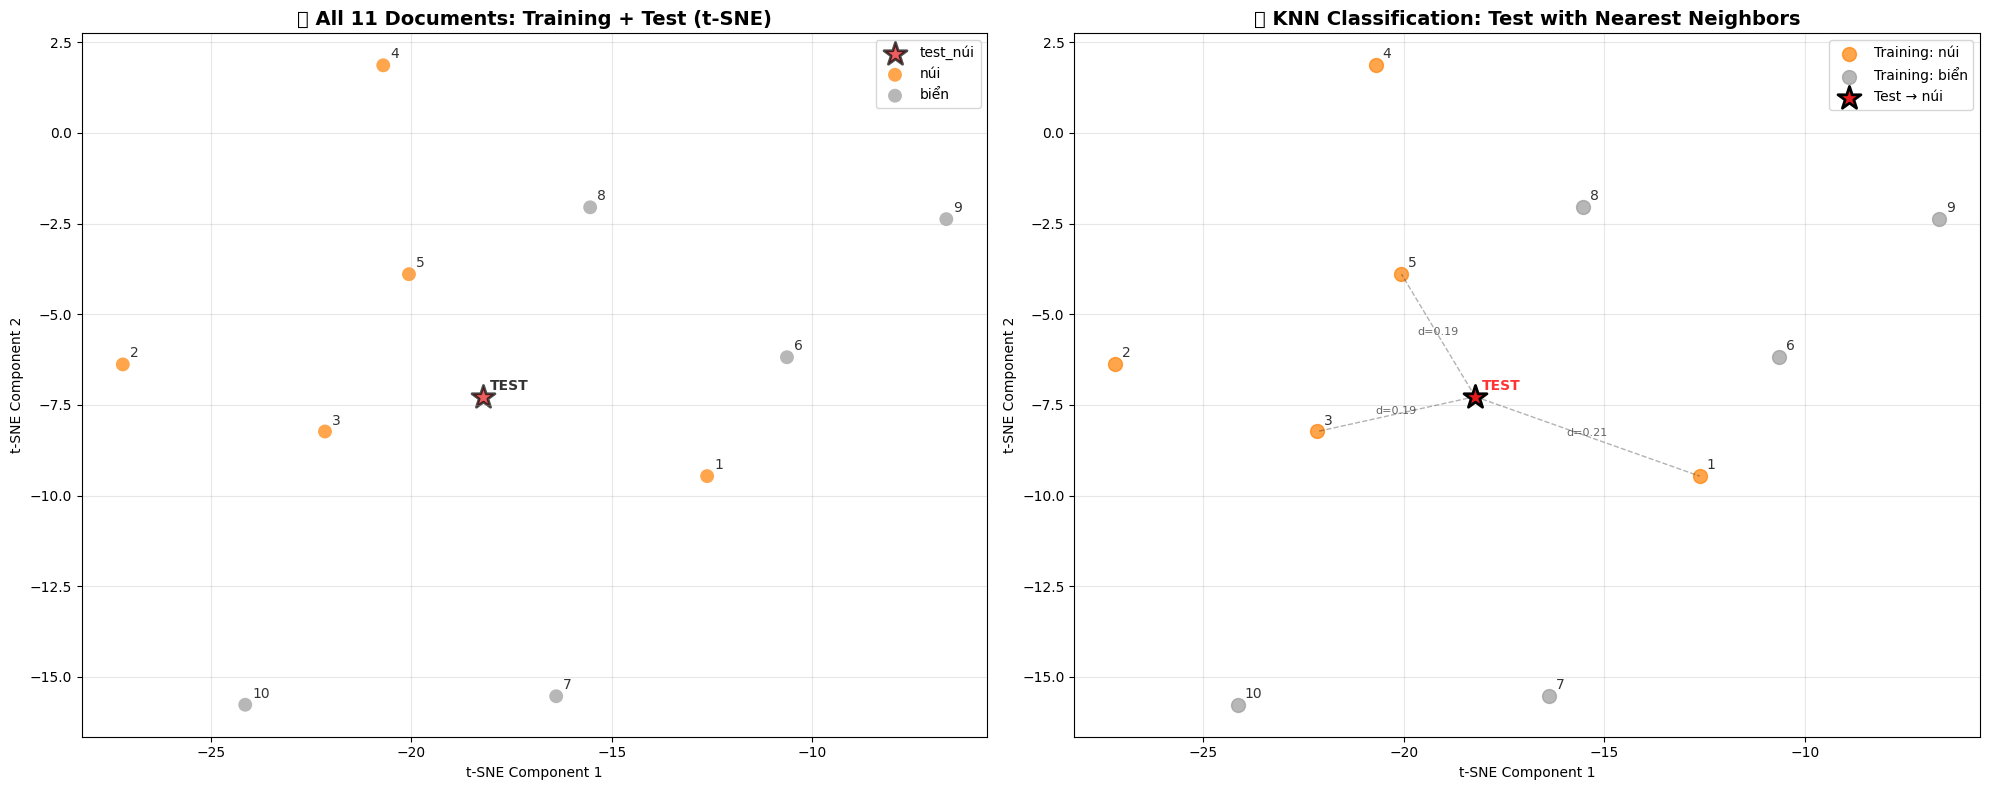


📊 VISUALIZATION SUMMARY:
📈 Total points visualized: 11
🎯 Test document: test.txt
🔮 Predicted as: núi
📍 Test point marked with ⭐ (star)
🔗 Dashed lines show k=3 nearest neighbors


In [11]:
# ========================================================================
# 📊 VISUALIZATION: 11 Document Vectors (10 training + 1 test)
# ========================================================================
print("🎨 CREATING COMPREHENSIVE VISUALIZATION")
print("=" * 60)
print("📊 Showing all 11 documents: 10 training + 1 test")
print()

if len(X) >= 4:  # Need minimum samples for t-SNE
    print("🎨 Creating t-SNE visualization for all 11 documents...")
    
    # Prepare data for visualization
    X_viz = X.copy()
    y_viz = y.copy()
    files_viz = file_nums.copy()
    
    # Add test document if available
    if 'test_vector' in locals():
        X_viz = np.vstack([X_viz, test_vector])
        y_viz = np.append(y_viz, f"test_{prediction}")  # Show predicted class
        files_viz.append("TEST")
        print(f"✅ Added test document with predicted label: {prediction}")
    
    print(f"📊 Total documents for visualization: {len(X_viz)}")
    print(f"   - Training: {len(X)} documents")
    print(f"   - Test: 1 document")
    print()
    
    # Apply t-SNE
    perplexity = min(5, len(X_viz) - 1)
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=RANDOM_SEED, max_iter=1000)
    X_2d = tsne.fit_transform(X_viz)
    
    # Create comprehensive visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: All documents with labels
    unique_labels = list(set(y_viz))
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))
    color_map = dict(zip(unique_labels, colors))
    
    for label in unique_labels:
        mask = y_viz == label
        marker = 'o' if 'test' not in label else '*'  # Star for test document
        size = 100 if 'test' not in label else 300  # Larger for test
        ax1.scatter(X_2d[mask, 0], X_2d[mask, 1], 
                   c=[color_map[label]], label=label, s=size, alpha=0.7, marker=marker,
                   edgecolors='black' if 'test' in label else 'none', linewidths=2)
    
    # Add file labels
    for i, file_id in enumerate(files_viz):
        ax1.annotate(str(file_id), (X_2d[i, 0], X_2d[i, 1]), 
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=10, alpha=0.8, fontweight='bold' if file_id == 'TEST' else 'normal')
    
    ax1.set_title('📊 All 11 Documents: Training + Test (t-SNE)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('t-SNE Component 1')
    ax1.set_ylabel('t-SNE Component 2')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Focus on classification with nearest neighbors
    training_mask = y_viz != f"test_{prediction}"
    test_mask = y_viz == f"test_{prediction}"
    
    # Plot training points by true label
    for label in ['núi', 'biển']:
        label_mask = y_viz == label
        ax2.scatter(X_2d[label_mask, 0], X_2d[label_mask, 1], 
                   c=[color_map[label]], s=100, alpha=0.7, label=f'Training: {label}')
    
    # Plot test point
    if np.any(test_mask):
        ax2.scatter(X_2d[test_mask, 0], X_2d[test_mask, 1], 
                   c=[color_map[y_viz[test_mask][0]]], s=300, marker='*', 
                   edgecolors='black', linewidths=2, label=f'Test → {prediction}', zorder=10)
        
        # Draw lines to nearest neighbors
        test_idx = np.where(test_mask)[0][0]
        for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
            ax2.plot([X_2d[test_idx, 0], X_2d[idx, 0]], 
                    [X_2d[test_idx, 1], X_2d[idx, 1]], 
                    'k--', alpha=0.3, linewidth=1)
            # Add distance annotation
            mid_x = (X_2d[test_idx, 0] + X_2d[idx, 0]) / 2
            mid_y = (X_2d[test_idx, 1] + X_2d[idx, 1]) / 2
            ax2.annotate(f'd={dist:.2f}', (mid_x, mid_y), 
                        fontsize=8, alpha=0.6, ha='center')
    
    # Add file labels
    for i, file_id in enumerate(files_viz):
        color = 'red' if file_id == 'TEST' else 'black'
        weight = 'bold' if file_id == 'TEST' else 'normal'
        ax2.annotate(str(file_id), (X_2d[i, 0], X_2d[i, 1]), 
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=10, alpha=0.8, color=color, fontweight=weight)
    
    ax2.set_title('🎯 KNN Classification: Test with Nearest Neighbors', fontsize=14, fontweight='bold')
    ax2.set_xlabel('t-SNE Component 1')
    ax2.set_ylabel('t-SNE Component 2')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n📊 VISUALIZATION SUMMARY:")
    print("=" * 40)
    print(f"📈 Total points visualized: {len(X_viz)}")
    print(f"🎯 Test document: {TEST_FILE}")
    print(f"🔮 Predicted as: {prediction}")
    print(f"📍 Test point marked with ⭐ (star)")
    print(f"🔗 Dashed lines show k={KNN_K} nearest neighbors")
    print("=" * 40)
else:
    print("⚠️ Insufficient data for t-SNE visualization (need >= 4 samples)")